## House Prices: Advanced Regression Techniques

The aim of this competition is to predict the sale price of residential homes in Ames, Iowa. We will practice feature engineering and regression algorithms to achieve the lowest prediction error (RMSE is the metric used in this competition).

General description and data are available on [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

1. [Load Dataset](#1)

2. [Data Processing](#2)

3. [Features Engineering](#3)

4. [Modeling](#4)

## <a name="1">Load Dataset</a>

In [1]:
import pandas as pd

train=pd.read_csv("data/train.csv")
test=pd.read_csv("data/test.csv")

In [2]:
# Let's display the first five rows of the train dataset
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Let's display the first five rows of the test dataset
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [2]:
train_ID=train["Id"]
test_ID=test["Id"]

train.drop("Id",1,inplace=True)
test.drop("Id",1,inplace=True)

print("The train data size after dropping Id feature is: {}".format(train.shape))
print("The test data size after dropping Id feature is: {}".format(test.shape))

The train data size after dropping Id feature is: (1460, 80)
The test data size after dropping Id feature is: (1459, 79)


## <a name="2">Data Processing</a>

**Outliers**

Let's explore these outliers:

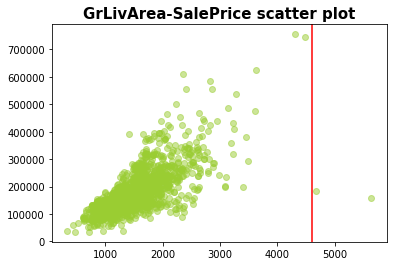

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(x=train["GrLivArea"],y=train["SalePrice"],color="yellowgreen",alpha=0.5)
plt.axvline(x=4600,color="r",linestyle="-")
plt.title("GrLivArea-SalePrice scatter plot",fontsize=15,weight="bold")
plt.show()

We can see at the bottom right two with extremely large values. These values are huge outliers. Therefore, we can safely delete them.

In [4]:
# Deleting outliers
train=train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index)

We decided to delete these two as they are very huge and really bad (extremely large areas for very low prices).

There are probably more outliers in the training data. However, removing all of them may affect badly our models if ever there were outliers in the test data. That's why, instead of removing all of them, we will just manage to make some of our models robust on them.

**Target Variable**

SalePrice is the variable we need to predict.


 mu=180932.92 and sigma=79467.79



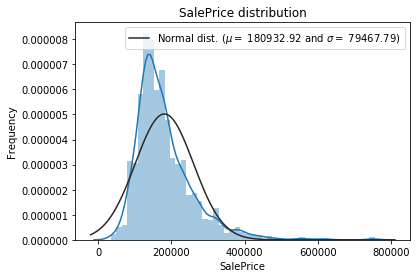

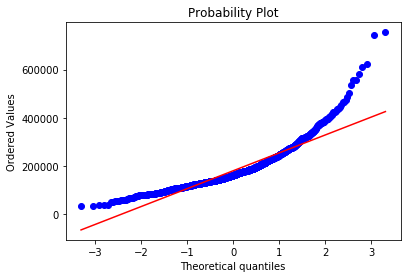

In [5]:
from scipy.stats import norm,probplot

sns.distplot(train["SalePrice"],fit=norm)

mu,sigma=norm.fit(train["SalePrice"])
print("\n mu={:.2f} and sigma={:.2f}\n".format(mu,sigma))

plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)],loc="best")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

# Get also the Q-Q plot
fig=plt.figure()
res=probplot(train["SalePrice"],plot=plt)
plt.show()

We need to transform this variable and make it more normally distributed.

**Log-transformation of the target variable**

In [6]:
import numpy as np


 mu=12.02 and sigma=0.40



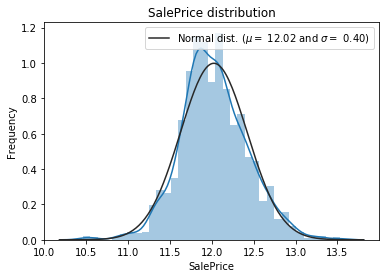

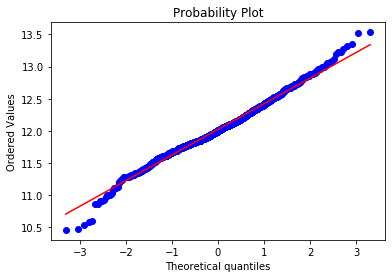

In [7]:
# Let's use the log1p function
# This function applies log(1+x) to all elements of the column
train["SalePrice"]=np.log1p(train["SalePrice"])

# Let's check the new distribution
sns.distplot(train["SalePrice"],fit=norm)

mu,sigma=norm.fit(train["SalePrice"])
print("\n mu={:.2f} and sigma={:.2f}\n".format(mu,sigma))

plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)],loc="best")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

# Get also the Q-Q plot
fig=plt.figure()
res=probplot(train["SalePrice"],plot=plt)
plt.show()

The data appear more normally distributed.

## <a name="3">Features Engineering</a>

In [10]:
ntrain=train.shape[0]
ntest=test.shape[0]

y_train=train["SalePrice"].values

df=pd.concat((train,test)).reset_index(drop=True)
df.drop("SalePrice",1,inplace=True)

print("The columns of the dataset are: {}".format(df.columns))

print("The shape of the dataframe is: {}".format(df.shape))

The columns of the dataset are: Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'Pa

Let's have a look at the correlation between numerical features and the target "SalePrice", in order to have a first idea of the connections between features.

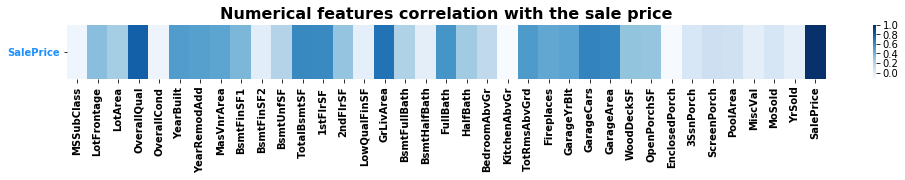

In [5]:
num=train.select_dtypes(exclude="object")
numcorr=num.corr()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(numcorr.sort_values(by=["SalePrice"],ascending=False).head(1),cmap="Blues")
plt.title("Numerical features correlation with the sale price",weight="bold",fontsize=16)
plt.xticks(weight="bold")
plt.yticks(weight="bold",color="dodgerblue",rotation=0)
plt.show()

In [6]:
numcorr["SalePrice"].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

The overall quality, the living area, basement area, garage cars and garage area have the highest correlation values with the sale price, which is logical, better quality and bigger area = Higher price.

Also some features such as, full bath or 1st floor surface have a higher correlation, those are luxury features, more luxury = Higher price.

And Year built, the newer buildings seem to have higher sale prices.

**Example of a strong correlation between 2 numerical features**

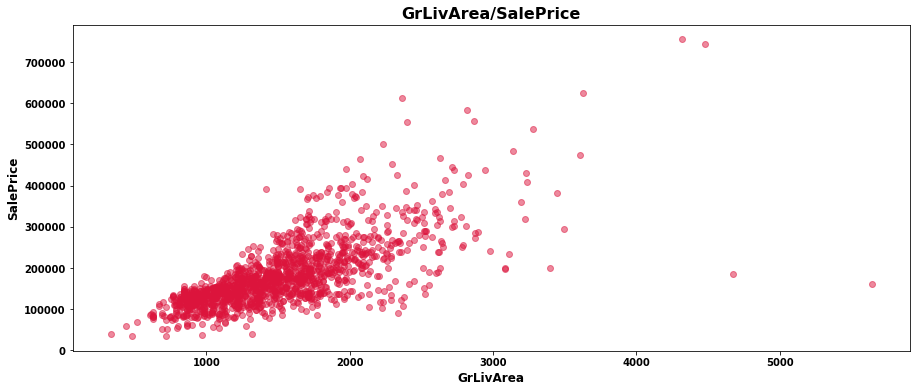

In [7]:
plt.figure(figsize=(15,6))
plt.scatter(x=train["GrLivArea"],y=train["SalePrice"],color="crimson",alpha=0.5)
plt.title("GrLivArea/SalePrice",weight="bold",fontsize=16)
plt.xlabel("GrLivArea",weight="bold",fontsize=12)
plt.ylabel("SalePrice",weight="bold",fontsize=12)
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.show()

**Correlation Matrix**

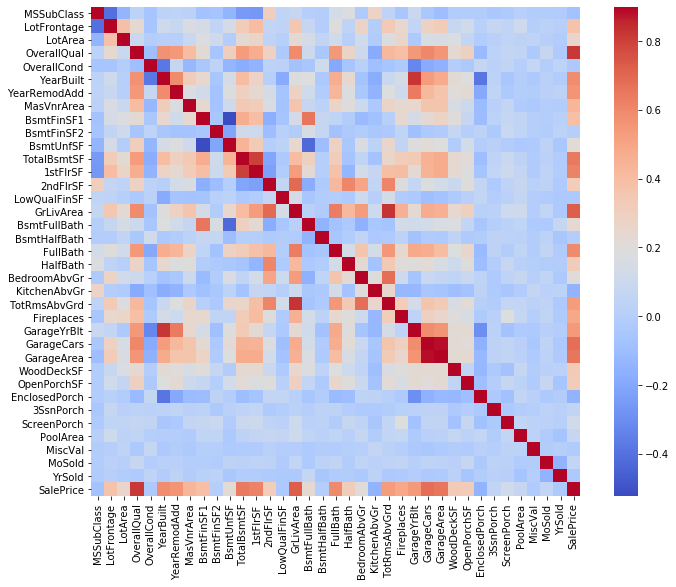

In [120]:
correlations=train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(correlations,vmax=0.9,square=True,cmap="coolwarm")
plt.show()

**Missing Data**

In [11]:
df_na=(df.isnull().sum()/len(df))*100
df_na=df_na.drop(df_na[df_na==0].index).sort_values(ascending=False)[:30]
missing_data=pd.DataFrame({"Missing Ratio":df_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


**Imputing missing values**

In [12]:
df["PoolQC"]=df["PoolQC"].fillna("None")
df["MiscFeature"]=df["MiscFeature"].fillna("None")
df["Alley"]=df["Alley"].fillna("None")
df["Fence"]=df["Fence"].fillna("None")
df["FireplaceQu"]=df["FireplaceQu"].fillna("None")
df["LotFrontage"]=df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ("GarageType","GarageFinish","GarageQual","GarageCond"):
    df[col]=df[col].fillna("None")
for col in ("GarageYrBlt","GarageArea","GarageCars"):
    df[col]=df[col].fillna(0)
for col in ("BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath"):
    df[col]=df[col].fillna(0)
for col in ("BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"):
    df[col]=df[col].fillna("None")
df["MasVnrType"]=df["MasVnrType"].fillna("None")
df["MasVnrArea"]=df["MasVnrArea"].fillna(0)
df["MSZoning"]=df["MSZoning"].fillna(df["MSZoning"].mode()[0])
df.drop("Utilities",1,inplace=True)
df["Functional"]=df["Functional"].fillna("Typ")
df["Electrical"]=df["Electrical"].fillna(df["Electrical"].mode()[0])
df["KitchenQual"]=df["KitchenQual"].fillna(df["KitchenQual"].mode()[0])
df["Exterior1st"]=df["Exterior1st"].fillna(df["Exterior1st"].mode()[0])
df["Exterior2nd"]=df["Exterior2nd"].fillna(df["Exterior2nd"].mode()[0])
df["SaleType"]=df["SaleType"].fillna(df["SaleType"].mode()[0])
df["MSSubClass"]=df["MSSubClass"].fillna("None")

In [13]:
# Let's check if there are more missing values
df_na=(df.isnull().sum()/len(df))*100
df_na=df_na.drop(df_na[df_na==0].index).sort_values(ascending=False)[:30]
missing_data=pd.DataFrame({"Missing Ratio":df_na})
missing_data.head()

,Missing Ratio


**Label Encoding some categorical variables**

In [14]:
from sklearn.preprocessing import LabelEncoder

cols=["FireplaceQu","BsmtQual","BsmtCond","GarageQual","GarageCond","ExterQual","ExterCond","HeatingQC","PoolQC","KitchenQual",
     "BsmtFinType1","BsmtFinType2","Functional","Fence","BsmtExposure","GarageFinish","LandSlope","LotShape","PavedDrive",
     "Street","Alley","CentralAir","MSSubClass","OverallCond","YrSold","MoSold"]

# let's apply LabelEncoder to categorical features
for col in cols:
    lbl=LabelEncoder()
    lbl.fit(list(df[col].values))
    df[col]=lbl.transform(list(df[col].values))
    
print("The shape of the dataframe is: {}".format(df.shape))

The shape of the dataframe is: (2917, 78)


**Adding one more feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of the basement, first and second floor of each house.

In [15]:
df["TotalSF"]=df["TotalBsmtSF"]+df["1stFlrSF"]+df["2ndFlrSF"]

**Skewed features**

In [16]:
from scipy.stats import skew

numeric_features=df.dtypes[df.dtypes!="object"].index

# Let's check the skew of all numerical features
skewed_features=df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("Skew in numerical features: {}".format(skewed_features))
skewed_df=pd.DataFrame({"Skew":skewed_features})
skewed_df.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


**Box Cox Transformation of (highly) skewed features**

In [17]:
skewed_df=skewed_df[abs(skewed_df)>0.75]
print("There are {} skewed numerical features".format(skewed_df.shape[0]))

from scipy.special import boxcox1p

skewed_features=skewed_df.index
lam=0.15
for feature in skewed_features:
    df[feature]=boxcox1p(df[feature],lam)

There are 59 skewed numerical features


**Getting dummy categorical features**

In [18]:
df=pd.get_dummies(df)
print("The shape of the dataframe is: {}".format(df.shape))

The shape of the dataframe is: (2917, 220)


**Getting the new train and test sets**

In [19]:
train=df[:ntrain]
test=df[ntrain:]

## <a name="4">Modeling</a>

**Define a cross validation strategy**

In [20]:
from sklearn.model_selection import KFold,cross_val_score

k=5

def rmsle_cv(model):
    kf=KFold(k,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse=np.sqrt(-cross_val_score(model,train.values,y_train,scoring="neg_mean_squared_error",cv=kf))
    return rmse

**Base models**

**LASSO Regression**

This model may be very sensitive to outliers. So we need to make it more robust on them.

In [21]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

lasso=make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=1))

**Elastic Net Regression**

In [22]:
from sklearn.linear_model import ElasticNet

ENet=make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=3))

**Kernel Ridge Regression**

In [23]:
from sklearn.kernel_ridge import KernelRidge

KRR=KernelRidge(alpha=0.6,kernel="polynomial",degree=2,coef0=2.5)

**Gradient Boosting Regression**

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

GBoost=GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,max_features="sqrt",min_samples_leaf=15,
                                min_samples_split=10,loss="huber",random_state=5)

**XGBoost**

In [25]:
import xgboost as xgb

model_xgb=xgb.XGBRegressor(colsample_bytree=0.4603,gamma=0.0468,learning_rate=0.05,max_depth=3,min_child_weight=1.7817,
                            n_estimators=2200,reg_alpha=0.4640,reg_lambda=0.8571,subsample=0.5213,silent=1,random_state=7,nthread=-1)

**LightGBM**

In [26]:
import lightgbm as lgb

model_lgb=lgb.LGBMRegressor(objective="regression",num_leaves=5,learning_rate=0.05,n_estimators=720,max_bin=55,
                           bagging_fraction=0.8,bagging_freq=5,feature_fraction=0.2319,feature_fraction_seed=9,bagging_seed=9,
                           min_data_in_leaf=6,min_sum_hessian_in_leaf=11)

**Base models scores**

Let's see how these base models performed on the data by evaluating the cross-validation rmsle error:

In [27]:
score=rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(),score.std()))

Lasso score: 0.1116 (0.0072)


In [28]:
score=rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})".format(score.mean(),score.std()))

ElasticNet score: 0.1116 (0.0072)


In [29]:
score=rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})".format(score.mean(),score.std()))

Kernel Ridge score: 0.1153 (0.0071)


In [30]:
score=rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})".format(score.mean(),score.std()))

Gradient Boosting score: 0.1181 (0.0088)


In [31]:
score=rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})".format(score.mean(),score.std()))

XGBoost score: 0.1152 (0.0067)


In [32]:
score=rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})".format(score.mean(),score.std()))

LGBM score: 0.1165 (0.0068)


**Stacking models**

In [33]:
from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin,clone

**Averaging base models**

We begin with this simple approach of averaging base models.

In [34]:
class AveragingModels(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,models):
        self.models=models
    
    # let's define clones of the original models to fit the data in
    def fit(self,X,y):
        self.models_=[clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X,y)
        
        return self
    
    def predict(self,X):
        predictions=np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions,axis=1)

We just average four models here ENet,GBoost,KRR and lasso.

In [35]:
averaged_models=AveragingModels(models=(ENet,GBoost,KRR,lasso))

score=rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})".format(score.mean(),score.std()))

Averaged base models score: 0.1091 (0.0074)


**Adding a Meta-model**

In this approach, we add a meta-model on the averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:
1. Split the training set into two parts: train and holdout
2. Train several base models on the first part (train)
3. Test these base models on the second part (holdout)
4. Use the predictions (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train the meta-model.

For example, if we take a 5-fold stacking, we first split the training set into 5 folds. Then we will do 5 iterations and in each iteration, we will train the base model on 4 folds and predict on the remaining fold (holdout fold).  
And after 5 iterations we will be sure that the entire data is used to get the out-of-folds predictions that we will use as features to train our meta-model. For the prediction part, we average the predictions of all base models on the test data and use the averaged predictions as meta-features for the final prediction done by the meta-model.

In [36]:
class StackingAveragedModels(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,base_models,meta_model,n_folds=5):
        self.base_models=base_models
        self.meta_model=meta_model
        self.n_folds=n_folds

    def fit(self,X,y):
        self.base_models_=[list() for x in self.base_models]
        self.meta_model_=clone(self.meta_model)
        kfold=KFold(n_splits=self.n_folds,shuffle=True,random_state=156)
        
        # Let's train cloned base models and create out-of-fold predictions
        out_of_fold_predictions=np.zeros((X.shape[0],len(self.base_models)))
        for i,model in enumerate(self.base_models):
            for train_index,holdout_index in kfold.split(X,y):
                instance=clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index],y[train_index])
                y_pred=instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index,i]=y_pred
        
        # Let's train the cloned meta-model using the out-of-fold predictions as new features
        self.meta_model_.fit(out_of_fold_predictions,y)
        return self
    
    # Do the predictions of all base models on the test data
    # and use the averaged predictions as meta-features for the final prediction done by the meta-model
    def predict(self,X):
        meta_features=np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

In [37]:
stacked_averaged_models=StackingAveragedModels(base_models=(ENet,GBoost,KRR),meta_model=lasso)

score=rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(),score.std()))

Stacking Averaged models score: 0.1083 (0.0072)


**Ensembling StackedRegressor, XGBoost and LightGBM**

Let's add XGBoost and LightGBM to the StackedRegressor defined previously.

In [38]:
from sklearn.metrics import mean_squared_error

In [41]:
def rmsle(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

**Final Training and Prediction**

**StackedRegressor**

In [42]:
stacked_averaged_models.fit(train.values,y_train)
stacked_train_pred=stacked_averaged_models.predict(train.values)
stacked_pred=np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train,stacked_train_pred))

0.07814176540831025


**XGBoost**

In [45]:
model_xgb.fit(train.values,y_train)
xgb_train_pred=model_xgb.predict(train.values)
xgb_pred=np.expm1(model_xgb.predict(test.values))
print(rmsle(y_train,xgb_train_pred))

0.07918776831272367


**LightGBM**

In [46]:
model_lgb.fit(train.values,y_train)
lgb_train_pred=model_lgb.predict(train.values)
lgb_pred=np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train,lgb_train_pred))

0.07252004835479434


RMSE on the entire Train data when averaging:

In [51]:
print("RMSLE score on training data: {}".format(rmsle(y_train,stacked_train_pred*0.70+xgb_train_pred*0.15+lgb_train_pred*0.15)))

RMSLE score on training data: 0.07545821384601174


**Ensemble prediction**

In [52]:
ensemble=stacked_pred*0.70+xgb_pred*0.15+lgb_pred*0.15

**Create csv to upload to Kaggle**

In [53]:
temp=pd.DataFrame(pd.read_csv("data/test.csv")["Id"])
temp["SalePrice"]=ensemble
temp.to_csv("output/submission.csv",index=False)